In [2]:
!pip install imgaug
import pandas as pd
import os
import json
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Dropout
from keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import imgaug.augmenters as iaa
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import warnings

warnings.filterwarnings("ignore")
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/train2014.zip -d /content/train2014
!unzip /content/drive/MyDrive/v2_Annotations_Train_mscoco.zip -d /content/annotations
!unzip /content/drive/MyDrive/v2_Questions_Train_mscoco.zip -d /content/questions
!unzip /content/drive/MyDrive/glove.zip -d /content

Streaming output truncated to the last 5000 lines.
 extracting: /content/train2014/train2014/COCO_train2014_000000200024.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000435713.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000249993.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000424160.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000142761.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000532668.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000564904.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000346384.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000560934.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000122356.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000193042.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000072702.jpg  
 extracting: /content/train2014/train

1/1 [==============================] - 2s 2s/step


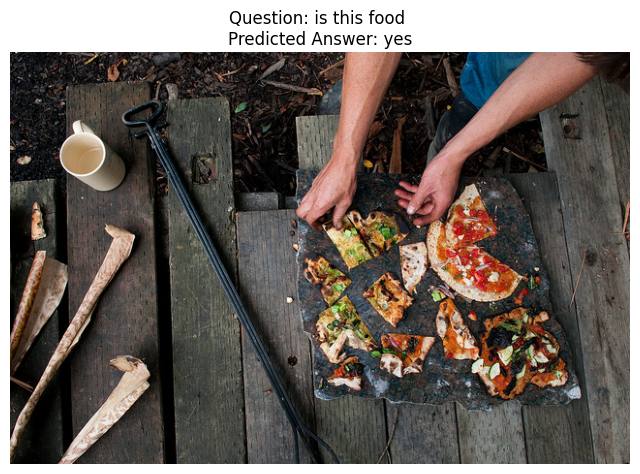

In [9]:
#!pip install joblib
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

# set up functions for data loader
aug1 = iaa.Fliplr(0.5)
aug2 = iaa.AddToBrightness((-30, -20))
aug3 = iaa.LinearContrast((0.6, 0.75))

def get_input1(que):
    t=Tokenizer(filters='')
    que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
    return que_arr

def get_input2(path):

    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image at path {path} could not be loaded.")

    if not isinstance(img, np.ndarray):
        raise TypeError(f"Expected img to be a numpy array, got {type(img)}")

    a = np.random.uniform()
    if a<0.25:
        img = aug1.augment_image(img)
    elif a<0.5:
        img = aug2.augment_image(img)
    elif a<0.75:
        img = aug3.augment_image(img)
    else:
        img = img
    img = cv2.resize(img, (224, 224))

    img = np.array(img)/255.0

    return img

# Single image path and question
single_image_path = '/content/train2014/train2014/COCO_train2014_000000345585.jpg'  # Replace with your image path
single_question = "is this food"

# Preprocess inputs
img_input = get_input2(single_image_path)
question_input = get_input1(single_question)

# Predict
model_lstm_vgg19 = load_model("/content/drive/MyDrive/model_lstm_vgg19_1123231222.h5")
labelencoder = joblib.load("/content/drive/MyDrive/labelencoder_1123231222.pkl")
predicted = model_lstm_vgg19.predict([np.expand_dims(question_input, axis=0), np.expand_dims(img_input, axis=0)])
predicted_answer = labelencoder.inverse_transform([np.argmax(predicted)])[0]

# Plotting
plt.figure(figsize=(8, 6))
img = plt.imread(single_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Question: {single_question} \nPredicted Answer: {predicted_answer}')
plt.show()